In [ ]:
!pip install opencv-contrib-python==3.4.2.16

In [ ]:
#Importation des librairies

import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
from scipy import spatial
from tqdm import tqdm
import time
import seaborn as sn
import pandas as pd
from cm import *
from sklearn.metrics import confusion_matrix

K = 5
length_desc = 128
THRESHOLD = 0.6

# Définition des fonctions à utiliser


In [ ]:
# Conversion des images en niveau de gris

def RGB_to_GRAY(t_RGB):
    t_gray = [0] * t_RGB.shape[0]
    for i, img in enumerate(t_RGB):
        t_gray[i] = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    return np.array(t_gray)


# Calcul des descripteurs locaux pour chaque image

def description(t_images, t_image_gray):
    sift = cv.xfeatures2d.SIFT_create()
    t_descripteurs = [0] * t_images.shape[0]
    t_kp = [0] * t_images.shape[0]
    t_list_kp = [0] * t_images.shape[0]
    
    for i, img in enumerate(t_image_gray):
        kp, des = sift.detectAndCompute(img, None)
        t_descripteurs[i] = des
        t_kp[i] = cv.drawKeypoints(img, kp, t_images[i].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        t_list_kp[i] = kp
        
    return np.array(t_descripteurs), np.array(t_kp), np.array(t_list_kp)



# Recupère 2 tableaux de vecteur
# Retourne les vecteurs du 2eme tableau correspondant au 1er tableau, et
# Retourne le score = nbre de correspondance / nbre de descripteur du 2eme tableau

def matching(vecteurs_ent, vecteurs_test, THRESHOLD):
    key_ent_to_test = []
    
    if vecteurs_test is not None:
        result = [None] * vecteurs_test.shape[0]
        correspondance = 0

        tree = spatial.KDTree(vecteurs_ent)

        # distance_ecl est classer par ordre de distance la plus courte
        distance_ecl, index = tree.query(vecteurs_test, p=2, k=2)

        for k, (dist, ind) in enumerate(zip(distance_ecl, index)):

            # On calcule le ratio entre la distance la plus courte et la deuxième plus courte distance
            ratio = dist[0] / dist[1]
            if ratio < THRESHOLD:
                # Appariement croisé
                tree_2 = spatial.KDTree(vecteurs_test)

                distance_ecl_2, index_2 = tree_2.query(vecteurs_ent[ind[0]], p=2, k=2)

                # Si le ration  est inférieur au seuil
                # Allors il ya correspondance des deux cotés
                ratio_2 = distance_ecl_2[0] / distance_ecl_2[1]
                if ratio_2 < THRESHOLD:
                    # Vérification de la rigidité locale en comparant l'angle entre les 2 gradients ???
                    result[k] = vecteurs_ent[ind[0]]
                    key_ent_to_test.append(cv.DMatch(ind[0], index_2[0], distance_ecl_2[0]))
                    correspondance += 1
                else:
                    result[k] = None
            else:
                result[k] = None

        return correspondance/vecteurs_ent.shape[0], result, key_ent_to_test
    else:
        return 0, [], key_ent_to_test



# Calcul du score de correspondance entre les descripteurs d'une images et les descripteurs
# des images d'entrainement
# Retourne un tableau (De même taille desc_img_entrainement) correspondant aux différents score

def score_match(desc_img_ent, desc_img_test, threshold):
    result = []
    d_match = []

    for i, img in enumerate(desc_img_ent):
        dm = []
        if isinstance(img, type(None)):
            score = 0
        else:
            score, _, dm = matching(img, desc_img_test, threshold)
        result.append(score)
        d_match.append(dm)

    return result, d_match


# Recherche des index des K plus grande valeur de score

def get_k_max_index(tab, d_match, k, labels_train):
    scores = [0] * k
    labels = [0] * k
    dm = [0] * k
    index_s = [0] * k

    for i in range(k):
        m = max(tab)
        index = tab.index(m)
        scores[i] = round(m, 2)
        labels[i] = labels_train[index]
        dm[i] = d_match[index]
        index_s[i] = index
        tab[index] = -1

    return np.array(list(zip(labels, scores, dm, index_s)))



# Prédiction à partir d'une image

def predict_img(img_path, THRESHOLD = 0.6, K = 5):
    image = cv.imread(img_path)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    descripteurs, _ = description(np.array([image]), np.array([image_gray]))
    return predict_desc(descripteurs[0], THRESHOLD, K)


# Prédiction à partir des descripteurs d'une image

def predict_desc(desc, descriptors_train, label_train, threshold, k):
    sc, d_match = score_match(descriptors_train, desc, threshold)
    p = get_k_max_index(sc, d_match, k, label_train)
    (objects, qte) = np.unique([i[0] for i in p], return_counts=True)
    arg = list(zip(objects, qte))
    arg = sorted(arg, key=lambda item: item[1], reverse=True)

    # We search for the predicted object with the highest score
    obj = arg[0][0]
    p = sorted(p, key=lambda item: item[1], reverse=True)
    # We return the first found
    for find in p:
        if obj == find[0]:
            return find


# Evaluation

def evaluate(THRESHOLD = 0.6, K = 5):
    predictions = [0] * labels_test.shape[0]
    with tqdm(total=labels_test.shape[0], desc="Prediction", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for i, des_test in enumerate(descripteurs_test):
            predictions[i] = predict_desc(des_test, descripteurs_train, labels_train, THRESHOLD, K)[0]
            pbar.update(1)
        
    return predictions

# Chargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chargement des Images

#path_img = 'Dataset2/'
path_img = '/content/drive/My Drive/Dataset2/'
liste_folder = [ f for f in os.listdir(path_img)]

images_objets = []
labels_objets = []

with tqdm(total=len(liste_folder), desc="Chargement", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for folder in liste_folder:
        liste_image = [ f for f in os.listdir(path_img+folder+"/") if os.path.isfile(os.path.join(path_img+folder+"/",f)) ]
        for img in liste_image:
            if img.split('.')[1] == 'jpg':
                image = cv.imread(os.path.join(path_img+folder+"/", img))
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                images_objets.append(image)
                labels_objets.append(folder)
        pbar.update(1)
    
images_objets = np.array(images_objets)
labels_objets = np.array(labels_objets)
print(images_objets.shape)
print(labels_objets.shape)

Chargement: 100%|██████████ [ time left: 00:00 ]

(738,)
(738,)


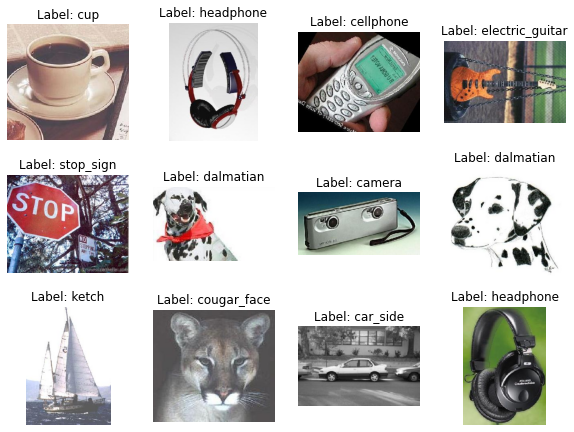

In [ ]:
# Affichage de quelques images

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_objets.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_objets[i], cmap='gray')
    plt.title('Label: {}'.format(labels_objets[i]))
    plt.axis("off")

# Décompte du nombre de classe

In [ ]:
print("Nous avons {} classes (Objets différents) dans notre dataset".format(len(np.unique(labels_objets))))

Nous avons 31 classes (Objets différents) dans notre dataset


# Division des données en train et test

In [ ]:
images_train, images_test, labels_train, labels_test = train_test_split(images_objets, labels_objets, test_size=0.5, random_state=42)

In [ ]:
print("Images d'entrainemment : {}".format(images_train.shape))
print("Labels d'entrainemment : {}".format(labels_train.shape))
print("Nous avons {} classes (Objets différents) dans notre train data".format(len(np.unique(labels_train))))
print()
print("Images de test : {}".format(images_test.shape))
print("Labels de test : {}".format(labels_test.shape))
print("Nous avons {} classes (Objets différents) dans notre test data".format(len(np.unique(labels_test))))

Images d'entrainemment : (369,)
Labels d'entrainemment : (369,)
Nous avons 31 classes (Objets différents) dans notre train data

Images de test : (369,)
Labels de test : (369,)
Nous avons 31 classes (Objets différents) dans notre test data


# Conversion des images d'entrainement et de test en gray

In [ ]:
images_train_gray = RGB_to_GRAY(images_train)

images_test_gray = RGB_to_GRAY(images_test)

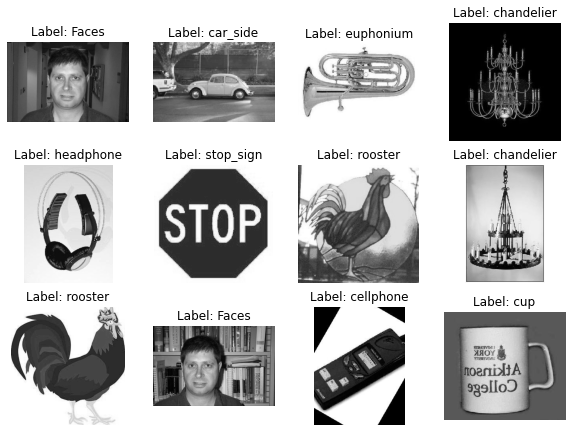

In [ ]:
# Affichage de quelques images d'entrainement en niveau de gris

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_train_gray.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_train_gray[i], cmap='gray')
    plt.title('Label: {}'.format(labels_train[i]))
    plt.axis("off")

# Calsuls des descripteurs locaux pour les images d'entrainement et de test

In [ ]:
descripteurs_train, images_kp_train, kp_train = description(images_train, images_train_gray)

descripteurs_test, images_kp_test, kp_test = description(images_test, images_test_gray)

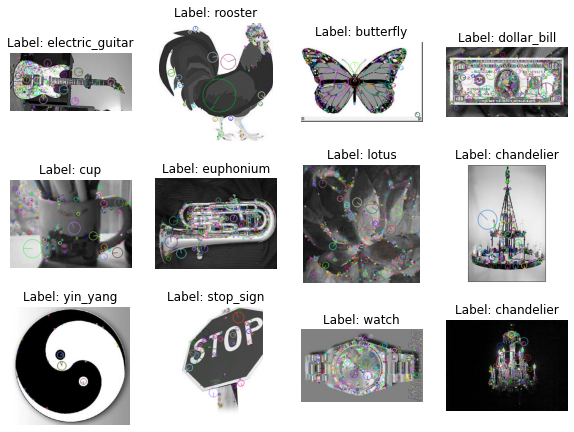

In [ ]:
# Affichage de quelques images d'entrainement avec leur description

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images_kp_train.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images_kp_train[i])
    plt.title('Label: {}'.format(labels_train[i]))
    plt.axis("off")

In [ ]:
# Affichage d'un descripteur
descripteurs_train[0][0]

array([  4.,  17.,  51.,  31.,   5.,   4.,   6.,   3.,  42.,  92.,  40.,
         5.,   0.,   1.,   4.,  30.,  14.,  36.,  43.,  50.,  16.,  24.,
        17.,  17.,   2.,  49.,  91.,  60.,  13.,  13.,  37.,   2.,  43.,
        12.,  11.,  22.,   1.,   0.,   0.,   5., 128.,  37.,  11.,   4.,
         0.,   5.,  23., 128.,  26.,  10.,  24.,  28.,  21., 128., 124.,
        69.,   1.,   4.,   7.,   7.,  30.,  79., 128.,   5.,  25.,   3.,
         0.,   0.,   0.,   0.,   0.,   4., 128.,  83.,  67.,  12.,   4.,
         1.,   1.,  30.,  16.,  58., 128.,  56.,   8.,  13.,   7.,   6.,
         0.,  73.,  94.,   7.,  37.,  22.,  14.,   4.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   2.,   3.,  17.,  42.,  11.,   1.,
         0.,   2.,   3.,  37., 128.,  77.,   6.,   0.,   0.,   0.,   8.,
       101., 128.,  16.,   7.,   0.,   1.,   1.], dtype=float32)

In [ ]:
# Sauvegarde des descripteurs
np.save('descripteurs.npy', descripteurs_train)
np.save('labels.npy', labels_train)
np.save('images.npy', images_train)

kp_train_old = kp_train.copy()
for i1, kp_t in enumerate(kp_train_old):
    if type(kp_t) is cv.KeyPoint:
        kp_train_old[i1] = (kp_t.pt, kp_t.size, kp_t.angle, kp_t.response, kp_t.octave, kp_t.class_id)
    else:
        for i2, kp_ in enumerate(kp_t):
            if type(kp_) is cv.KeyPoint:
                kp_train_old[i1][i2] = (kp_.pt, kp_.size, kp_.angle, kp_.response, kp_.octave, kp_.class_id)
            else:
                for i3, kp in enumerate(kp_):
                    if type(kp) is cv.KeyPoint:
                        kp_train_old[i1][i2][i3] = (kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
np.save('k_points.npy', kp_train_old)

In [ ]:
# Lecture du tableau sauvedardé
old_descripteurs = np.load('descripteurs.npy', allow_pickle=True)
old_labels = np.load('labels.npy', allow_pickle=True)
old_images = np.load('images.npy', allow_pickle=True)

old_k_points = np.load('k_points.npy', allow_pickle=True)
for i1, kp_t in enumerate(old_k_points):
    if type(kp_t) is tuple:
        old_k_points[i1] = cv.KeyPoint(x=kp_t[0][0], y=kp_t[0][1], _size=kp_t[1], _angle=kp_t[2], _response=kp_t[3], _octave=kp_t[4], _class_id=kp_t[5]) 
    else:
        for i2, kp_ in enumerate(kp_t):
            if type(kp_) is tuple:
                old_k_points[i1][i2] = cv.KeyPoint(x=kp_[0][0], y=kp_[0][1], _size=kp_[1], _angle=kp_[2], _response=kp_[3], _octave=kp_[4], _class_id=kp_[5]) 
            else:
                for i3, kp in enumerate(kp_):
                    if type(kp) is tuple:
                        old_k_points[i1][i2][i3] = cv.KeyPoint(x=kp[0][0], y=kp[0][1], _size=kp[1], _angle=kp[2], _response=kp[3], _octave=kp[4], _class_id=kp[5])


# Mise en correspondance (matching) de points d’intérêts

In [ ]:
c = score_match(descripteurs_train, descripteurs_test[10], 0.6)

# Recherche des index des K plus grande valeur de score

In [ ]:
pred = get_k_max_index(c[0], c[1], K, labels_train)

In [ ]:
pred

array([['stop_sign', 0.01, list([<DMatch 0x7f8910c23b90>]), 230],
       ['chair', 0.01, list([<DMatch 0x7f8910c23c10>]), 125],
       ['headphone', 0.01,
        list([<DMatch 0x7f8910c23e90>, <DMatch 0x7f8910c23ad0>]), 124],
       ['grand_piano', 0.01, list([<DMatch 0x7f8910c23d10>]), 163],
       ['strawberry', 0.0, list([<DMatch 0x7f891402f790>]), 114]],
      dtype=object)

In [ ]:
labels_test[10]

'strawberry'

# Visualisation des prédictions

In [ ]:
img_pred = 100
result = predict_desc(descripteurs_test[img_pred], descripteurs_train, labels_train, 0.6, 5)
result

array(['camera', 0.01, list([<DMatch 0x7f8910c23750>]), 112], dtype=object)

In [ ]:
out = cv.drawMatches(images_train[result[3]], kp_train[result[3]], images_test[img_pred],
                         kp_test[img_pred], result[2], None)

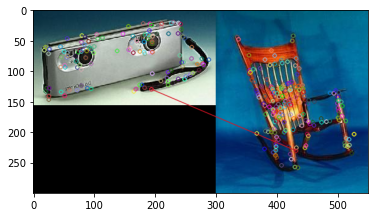

In [ ]:
plt.imshow(out)

# Evaluation

In [ ]:
label_pred = evaluate(0.6, 5)

In [ ]:
# Calcul du score
sum(label_pred == labels_test) / labels_test.shape[0]

In [ ]:
np.unique(labels_test)

# Matrice de confusion

In [ ]:
confm = confusion_matrix(labels_test, np.array(label_pred), np.unique(labels_test))

df_cm = pd.DataFrame(confm, index = [i for i in np.unique(labels_test)],
              columns = [i for i in np.unique(labels_test)])

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

In [ ]:
confm = confusion_matrix(labels_test, np.array(label_pred), np.unique(labels_test))

df_cm = pd.DataFrame(confm, index = [i for i in np.unique(labels_test)],
              columns = [i for i in np.unique(labels_test)])

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5, cbar=False)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()